In [1]:
import geopandas as gpd
import fiona
from shapely.geometry import shape
import matplotlib.pyplot as plt

features = []

with fiona.open("./Geospatial/Abila.shp") as src:
    for feature in src:
        geom_info = feature['geometry']
        geom_type = geom_info['type']
        coords = geom_info['coordinates']

        # ⚡ 在这里判断是否非法 LineString
        if geom_type == 'LineString' and (not coords or len(coords) < 2):
            continue  # 直接跳过非法 LineString

        # 转换为 shapely geometry（这一步就不会炸了）
        geom = shape(geom_info)
        features.append({
            'geometry': geom,
            **feature['properties']
        })

# 转成 GeoDataFrame
abila_gdf = gpd.GeoDataFrame(features)


In [2]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import re
from shapely.geometry import LineString, Point
import folium
from shapely.ops import unary_union


def parse_address(location):
    """解析地址字符串，返回结构化信息"""
    location = location.strip()

    # 交叉口形式
    if '/' in location:
        streets = [s.strip() for s in location.split('/')]
        return {'type': 'intersection', 'streets': streets}

    # 门牌号形式（或不带门牌号的普通地址）
    # 示例：4607 N. Barwyn St
    # 示例：N. Polvo St
    # 示例：Egeou Ave

    match = re.match(
        r"""^\s*
    (?:(\d+)\s+)?                         # 门牌号（可选）
    (?:(N|S|E|W|NE|NW|SE|SW)\.?\s+)?      # 方向前缀（可选）
    ([\w\s\-']+?)                         # 街道名称
    \s+(\w+)\.?\s*$                       # 放宽街道类型匹配（如 Pky, Pkwy, Av, etc.）
    """, location, re.IGNORECASE | re.VERBOSE
    )

    if not match:
        return None

    number, dir_prefix, name, st_type = match.groups()
    return {
        'type': 'address',
        'number': int(number) if number else None,
        'FEDIRP': dir_prefix.upper() if dir_prefix else None,
        'FENAME': name.strip(),
        'FETYPE': st_type
    }


def get_location_coords(location, abila_gdf):
    parsed = parse_address(location)
    # print(f"解析地址: {location} -> {parsed}")
    if not parsed:
        return None

    if parsed['type'] == 'intersection':
        streets = []
        for street in parsed['streets']:
            s = parse_address(street)
            if not s:
                return None
            # cond = (
            #     (abila_gdf['FENAME'].str.lower() == s['FENAME'].lower()) &
            #     (abila_gdf['FETYPE'].str.lower() == s['FETYPE'].lower())
            # )
            cond = ((abila_gdf['FENAME'].str.lower() == s['FENAME'].lower()))
            if s['FEDIRP']:
                cond &= (abila_gdf['FEDIRP'].str.upper()
                         == s['FEDIRP'].upper())
            match = abila_gdf[cond]
            if match.empty:
                print(f"❌ 找不到街道: {street}")
                return None
            streets.append(match)

        # 将所有匹配的线合并成一条（支持 MultiLine）
        line1 = unary_union(streets[0].geometry.tolist())
        line2 = unary_union(streets[1].geometry.tolist())

        # 计算交点
        intersection = line1.intersection(line2)

        # 返回第一个有效交点
        if isinstance(intersection, Point):
            return intersection.x, intersection.y
        elif intersection.geom_type == 'MultiPoint':
            return list(intersection.geoms)[0].x, list(intersection.geoms)[0].y
        elif intersection.geom_type == 'GeometryCollection':
            for geom in intersection.geoms:
                if isinstance(geom, Point):
                    return geom.x, geom.y
        print(f"⚠️ 没找到交点: {location}")
        return None

    elif parsed['type'] == 'address':
        # cond = (
        #     (abila_gdf['FENAME'].str.lower() == parsed['FENAME'].lower()) &
        #     (abila_gdf['FETYPE'].str.lower() == parsed['FETYPE'].lower())
        # )
        cond = ((abila_gdf['FENAME'].str.lower() == parsed['FENAME'].lower()))
        if parsed['FEDIRP']:
            cond &= (abila_gdf['FEDIRP'].str.upper()
                     == parsed['FEDIRP'].upper())
        matches = abila_gdf[cond]
        if matches.empty:
            print("❌ 没有匹配的街道段")
            return None

        if parsed['number'] is None:
            print("⚠️ 地址中不包含门牌号，无法精确定位")
            return None

        for _, row in matches.iterrows():
            addr_num = parsed['number']
            left = row.get('FRADDL'), row.get('TOADDL')
            right = row.get('FRADDR'), row.get('TOADDR')
            all_nums = list(filter(None, left + right))
            if not all_nums:
                continue
            min_num, max_num = min(all_nums), max(all_nums)
            if min_num <= addr_num <= max_num:
                # 返回线段中心
                midpoint = row.geometry.interpolate(0.5, normalized=True)
                return midpoint.x, midpoint.y

        print("❌ 不在范围内")
        return None

# import folium
# from IPython.display import display  # 仅用于 Jupyter

# def plot_locations_on_map(location_list, abila_gdf):
#     """画出街道地图和标记位置，并直接展示"""
#     m = folium.Map(location=[36.05, 24.84], zoom_start=15)

#     # 加入街道线
#     for geom in abila_gdf.geometry:
#         if isinstance(geom, LineString):
#             folium.PolyLine(locations=[(y, x) for x, y in geom.coords], color="gray", weight=1).add_to(m)

#     # 添加每个 location 的坐标点
#     for loc in location_list:
#         coords = get_location_coords(loc, abila_gdf)
#         if coords:
#             folium.Marker(
#                 location=(coords[1], coords[0]),
#                 popup=loc,
#                 icon=folium.Icon(color="red", icon="map-marker")
#             ).add_to(m)
#         else:
#             print(f"❗ 无法定位: {loc}")

#     display(m)


def plot_locations_on_map(location_list, abila_gdf):
    """使用 matplotlib 画出街道网络并标注位置"""
    fig, ax = plt.subplots(figsize=(10, 10))

    # 画街道线（GeoDataFrame 自带 plot 方法）
    abila_gdf.plot(ax=ax, linewidth=0.8, color='lightgray')

    # 标记所有地址点
    for loc in location_list:
        coords = get_location_coords(loc, abila_gdf)
        if coords:
            x, y = coords
            ax.plot(x, y, 'ro')  # 红色圆点
            ax.text(x + 0.0005, y + 0.0005, loc, fontsize=9)
        else:
            print(f"❗ 无法定位: {loc}")

    ax.set_title("Abila City Map with Locations", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.grid(True)
    plt.show()

(24.90051500000002, 36.054221)


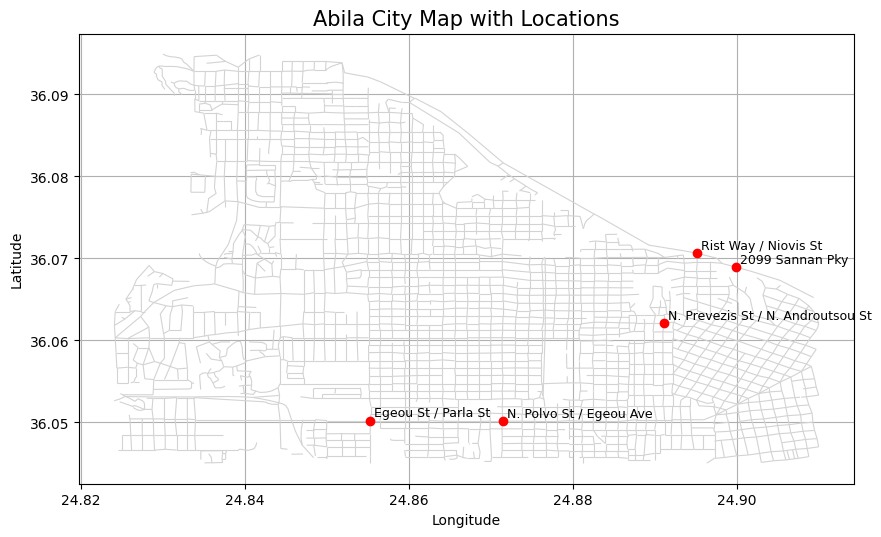

In [3]:
# 单个坐标获取
coord = get_location_coords("500 N. Schaber Ave", abila_gdf)
print(coord)

# 多个位置地图可视化
locations = [
    "2099 Sannan Pky",
    "N. Polvo St / Egeou Ave",
    "N. Prevezis St / N. Androutsou St",
    "Rist Way / Niovis St",
    "Egeou St / Parla St",
]
plot_locations_on_map(locations, abila_gdf)


📌 提取了 152 个有效地址。
❌ 不在范围内
❗ 无法定位: 3703 N. Pilau St
❗ 无法定位: N. Parla St from Egeou Ave North to N. Alm St
❌ 找不到街道: N. Pilai St
❗ 无法定位: N. Carnero St / N. Pilai St
❌ 没有匹配的街道段
❗ 无法定位: ALL UNITS
❌ 不在范围内
❗ 无法定位: 2299 N. Finiatur St


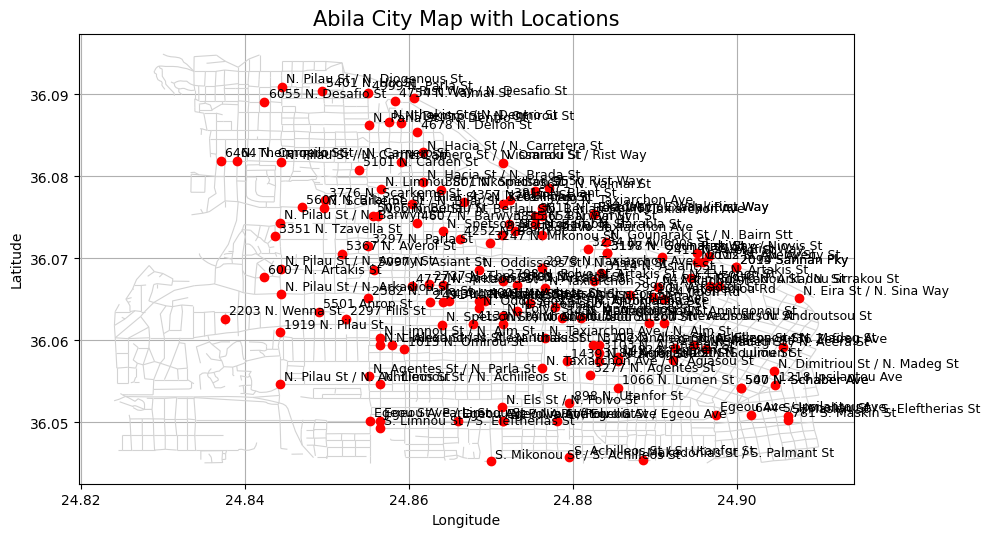

In [4]:
import pandas as pd
df1 = pd.read_csv("./csv-1700-1830.csv", encoding='latin1')
df2 = pd.read_csv("./csv-1831-2000.csv", encoding='latin1')
df3 = pd.read_csv("./csv-2001-2131.csv", encoding='latin1')
df = pd.concat([df1, df2, df3], ignore_index=True)
location_list = df[' location'].dropna().astype(str).unique().tolist()

print(f"📌 提取了 {len(location_list)} 个有效地址。")
# print(location_list)
plot_locations_on_map(location_list, abila_gdf)

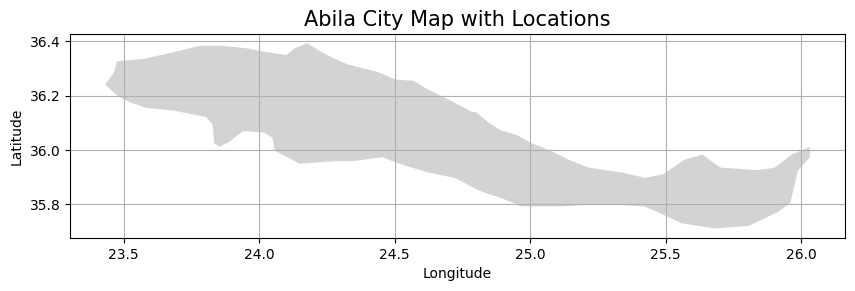

In [5]:
import geopandas as gpd
import fiona
from shapely.geometry import shape
import matplotlib.pyplot as plt

features = []

with fiona.open("./Geospatial/Kronos_Island.shp") as src:
    for feature in src:
        geom_info = feature['geometry']
        geom_type = geom_info['type']
        coords = geom_info['coordinates']

        # ⚡ 在这里判断是否非法 LineString
        if geom_type == 'LineString' and (not coords or len(coords) < 2):
            continue  # 直接跳过非法 LineString

        # 转换为 shapely geometry（这一步就不会炸了）
        geom = shape(geom_info)
        features.append({
            'geometry': geom,
            **feature['properties']
        })

# 转成 GeoDataFrame
kronos_gdf = gpd.GeoDataFrame(features)
plot_locations_on_map([], kronos_gdf)

In [ ]:
import re

class MBDATA:
    def __init__(self, date, author, message, location=None):
        self.date = date
        self.author = author
        self.message = message
        self.location = location

        # Parsed fields
        self.is_retweet = False
        self.retweet_author = None
        self.retweet_text = None
        self.mentions = []
        self.hashtags = []

        # Immediately parse message upon instantiation
        self.parse_message()

    def parse_message(self):
        """
        Populate:
          - is_retweet: bool
          - retweet_user: original author's username if RT
          - retweet_text: original message text if RT
          - mentions: list of usernames mentioned
          - hashtags: list of hashtags used
        """
        # Detect retweet pattern "RT @user: text"
        rt_match = re.match(r'^RT\s+@(?P<user>\w+):\s*(?P<text>.*)', self.message)
        if rt_match:
            self.is_retweet = True
            self.retweet_author = rt_match.group('user')
            self.retweet_text = rt_match.group('text')

        # Extract all @mentions and #hashtags
        self.mentions = re.findall(r'@(\w+)', self.message)
        self.hashtags = re.findall(r'#(\w+)', self.message)

    def to_dict(self):
        """
        Return all data as a dict, useful for DataFrame construction.
        """
        return {
            'date': self.date,
            'author': self.author,
            'message': self.message,
            'location': self.location,
            'is_retweet': self.is_retweet,
            'retweet_author': self.retweet_author,
            'retweet_text': self.retweet_text,
            'mentions': self.mentions,
            'hashtags': self.hashtags
        }

In [ ]:
class CCDATA:
    def __init__(self, date, message, location=None):
        self.date = date
        self.message = message
        self.location = location

        # Parsed fields
        self.incident_type = None
        self.status = None
        self.units_involved = []
        self.location_info = None
        self.priority_flag = False
        self.keywords = []

        self.parse_message()

    def parse_message(self):
        # Define common status and priority indicators
        status_keywords = ['IN PROGRESS', 'REPORT', 'REQUEST', 'CONTINUES']
        priority_keywords = ['OFFICER DOWN', 'DIRE EMERGENCY', 'SWAT TEAM']
        
        # 统一
        replace_dict ={
            'PURSUIT CONTINUES': 'PURSUIT-CONTINUES',
            'CRIME SCENE INVESTIGATION-REQUEST': 'CRIME SCENE INVESTIGATION REQUEST',
            'POLICE UNIT DISPATCHED': 'POLICE UNITS DISPATCHED',
        }
        self.message.replace(replace_dict)
        self.content = [d.strip() for d in self.message.split('-')]


        # Extract known status
        for status in status_keywords:
            if status in self.message:
                self.status = status
                break

        # Check for priority flags
        self.priority_flag = any(p in self.message for p in priority_keywords)

        # Extract units (police, fire, ambulance, etc.)
        self.units_involved = re.findall(r'(?:POLICE|FIRE|AMBULANCE|UNITS?)\s+(?:UNIT[S]?|TRUCK[S]?)?\s*#?[0-9]+', self.message)

        # Extract location/target info
        if 'BLACK VAN' in self.message:
            self.location_info = 'BLACK VAN'
        elif 'LOCATION' in self.message:
            loc_match = re.search(r'LOCATION[^-]*', self.message)
            self.location_info = loc_match.group().strip() if loc_match else None
        elif 'DWELLING' in self.message:
            self.location_info = 'DWELLING OF INTEREST'
        elif 'PERSON' in self.message:
            self.location_info = 'PERSON OF INTEREST'
        elif 'PEDESTRIAN' in self.message:
            self.location_info = 'PEDESTRIAN'

        # Store keywords (could be expanded with more logic)
        self.keywords = re.findall(r'\b[A-Z]{2,}(?:\s[A-Z]{2,})*\b', self.message)

    def to_dict(self):
        return {
            'date': self.date,
            'message': self.message,
            'location': self.location,
            'incident_type': self.incident_type,
            'status': self.status,
            'units_involved': self.units_involved,
            'location_info': self.location_info,
            'priority_flag': self.priority_flag,
            'keywords': self.keywords
        }

In [ ]:
import pandas as pd
df1 = pd.read_csv("./csv-1700-1830.csv", encoding='latin1')
df2 = pd.read_csv("./csv-1831-2000.csv", encoding='latin1')
df3 = pd.read_csv("./csv-2001-2131.csv", encoding='latin1')
df = pd.concat([df1, df2, df3], ignore_index=True)

用户画像分析

In [7]:
mbdata = df[df['type'] == 'mbdata']
mbdata

,type,date(yyyyMMddHHmmss),author,message,latitude,longitude,location
0,mbdata,20140123170000,POK,Follow us @POK-Kronos,NaN,NaN,NaN
1,mbdata,20140123170000,maha_Homeland,Don't miss a moment! Follow our live coverage...,NaN,NaN,NaN
2,mbdata,20140123170000,Viktor-E,Come join us in the Park! Music tonight at Abi...,NaN,NaN,NaN
3,mbdata,20140123170000,KronosStar,POK rally to start in Abila City Park. POK lea...,NaN,NaN,NaN
4,mbdata,20140123170000,AbilaPost,POK rally set to take place in Abila City Park...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4058,mbdata,20140123213310,plasticParts,RT @AbilaPost unknown explosion heard from the...,NaN,NaN,NaN
4059,mbdata,20140123213345,klingon4real,RT @CentralBulletin explosion heard at dancing...,NaN,NaN,NaN
4060,mbdata,20140123213400,lindyT,RT @KronosStar There has been an explosion fro...,NaN,NaN,NaN
4061,mbdata,20140123213400,dolls4sale,RT @redisrad What was that? #boom,NaN,NaN,NaN


In [8]:
ccdata = df[df['type'] == 'ccdata']
ccdata

,type,date(yyyyMMddHHmmss),author,message,latitude,longitude,location
9,ccdata,20140123170000,NaN,KEEP THE PEACE-CROWD CONTROL/ABILA CITY PARK,NaN,NaN,Egeou St / Parla St
28,ccdata,20140123170210,NaN,TRAFFIC STOP,NaN,NaN,N. Els St / N. Polvo St
59,ccdata,20140123170513,NaN,PARK CHECK,NaN,NaN,2099 Sannan Pky
123,ccdata,20140123171102,NaN,DISTURBANCE-NOISE,NaN,NaN,3654 N. Barwyn St
131,ccdata,20140123171153,NaN,ALARM-SECURE NO CRIME,NaN,NaN,3815 N. Blant St
...,...,...,...,...,...,...,...
3908,ccdata,20140123212111,NaN,DRUNK SUBJECT,NaN,NaN,2299 N. Finiatur St
3926,ccdata,20140123212200,NaN,CRIME SCENE INVESTIGATION-REQUEST-ADDITIONAL U...,NaN,NaN,1122 N. Maskin St
3983,ccdata,20140123212500,NaN,SUSPICIOUS SUBJECT/CIRCUMSTANCES-IN PROGRESS,NaN,NaN,S. Mikonou St / S. Achilleos St
4013,ccdata,20140123212712,NaN,TRAFFIC STOP,NaN,NaN,N. Pilau St / N. Diogenous St


In [23]:
ccdata_list = ccdata.to_dict(orient='records')
incident_dict = {}
for d in ccdata_list:
    content = [item.strip() for item in d['message'].split('-')]
    d['content'] = content

    current_level = incident_dict
    for part in content:
        if part not in current_level:
            current_level[part] = {}
        current_level = current_level[part]

status = []
for key in incident_dict:
    status.extend(incident_dict[key].keys())
    
for d in set(status):
    print(d)

CROWD CONTROL/ABILA CITY PARK
CROWD CONTROL
FIRE TRUCKS #41 AND #57 DISPATCHED TO FIRE
POLICE UNIT #253 IN PURSUIT
FELONY HIT & RUN
OFFICER DOWN
STREET CLOSURE
POLICE UNITS #101 AND #220 DISPATCHED TO FIRE
REQUEST
SECURE NO CRIME
BUILDING FIRE
NOISE
IN PROGRESS
BLACK VAN
AMBULANCE DISPATCHED
NO OR UNKNOWN INJURIES
CONTINUES
REPORT
LOCATION/PERSON/INCIDENT OF INTEREST
LOCATION/DWELLING OF INTEREST
AMUBLANCE DISPATCHED TO FIRE
PEDESTRIAN HIT & RUN
POLICE UNITS #253 AND #357/SECOND UNIT JOINS
FIRE TRUCK #23 DISPATCHED TO FIRE
